In [1]:
import tensorflow as tf
from keras import layers, losses
from keras.models import Model
import sklearn

In [2]:
import turbo as tb
import preprocessing as pr
import labeling as lb
import classification as cls
import rul_dataframe as rd
import plots as pl

import variational_autoencoder as vae_class

import copy
import numpy as np
import pandas as pd

In [4]:
class VAE_3L(Model):
    '''
    Variational Autoencoder with 3 layer encoder/decoder. Hidden units of size 
    h1 = Z(input * 1.2)
    h2 = Z(h1 * 0.5)
    h3 = Z(h3 * 0.5)
    Prior is unit gaussian.
    '''
    def __init__(self, input_dim, af):
        super(VAE_3L, self).__init__()
        self.input_dim = input_dim
        self.h1 = int(self.input_dim * 1.2)
        self.h2 = int(self.h1 * 0.5)
        self.h3 = int(self.h2 * 0.5)

        self.encoder = tf.keras.Sequential([
            layers.Dense(self.h1, activation=af),
            layers.Dense(self.h2, activation=af),
            layers.Dense(self.h3 + self.h3)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(self.h2, activation=af),
            layers.Dense(self.h1, activation=af),
        ])

        self.output_layer = layers.Dense(self.input_dim)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.h3))
        return self.decode(eps)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        output = self.output_layer(decoded)
        return output

    def make_prediction(self, features):
        m, v = self.encode(features)
        z = self.reparameterize(m, v)
        output = self.decode(z)
        return output

def log_pdf_function(sample, mean, logvar):
    '''calculates log of probability density function,
        log p(sample), sample ~ Normal(mean, exp(logvar)
        log((1/sqrt(var*2*pi))*exp(-.5((sample-mean)**2/var))
        = -.5 ( (sample-mean)**2 ) / var - .5 logvar - .5 log2pi
    '''
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=1)

def compute_loss_vae_mse(vae, x):
    m, v = vae.encode(x)
    z = vae.reparameterize(m, v)
    output = vae.decode(z)

    # Reconstruction Loss
    logpx_z = -tf.keras.metrics.mean_squared_error(x, output)

    logpz = log_pdf_function(z, 0., 0.) # prior
    logqz_x = log_pdf_function(z, m, v) # posterior

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_loss_mse2(vae, x):
    m1, v1 = vae.encode(x) # encodes distribution of latent space depending on x
    z = vae.reparameterize(m1, v1)
    output = vae.decode(z) # output distribution

    # 'Probability'
    logpx_z = -tf.keras.metrics.mean_squared_error(x, output)

    # KL Divergence
    dlk = -.5 * tf.reduce_sum(1 + v1 - m1 * m1 - tf.exp(v1), axis=1)

    return tf.reduce_mean(dlk - logpx_z)

def compute_loss_crossentr(vae, x):
    m1, v1 = vae.encode(x) # encodes distribution of latent space depending on x
    z = vae.reparameterize(m1, v1)
    output = vae.decode(z) # output distribution

    # 'Probability'
    logpx_z = tf.keras.losses.binary_crossentropy(x, output)

    # KL Divergence
    dlk = -.5 * tf.reduce_sum(1 + v1 - m1 * m1 - tf.exp(v1), axis=1)

    return tf.reduce_mean(dlk + logpx_z)

@tf.function
def train_step_mse(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss_vae_mse(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

@tf.function
def train_step_mse2(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss_mse2(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

@tf.function
def train_step_mse3(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss_crossentr(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [5]:
class VAE_3L_Theory(Model):
    '''
    Variational Autoencoder with 3 layer encoder/decoder. Hidden units of size 
    h1 = Z(input * 1.2)
    h2 = Z(h1 * 0.5)
    h3 = Z(h3 * 0.5)
    Prior is unit gaussian.
    '''
    def __init__(self, input_dim, af):
        super(VAE_3L_Theory, self).__init__()
        self.input_dim = input_dim
        self.h1 = int(self.input_dim * 1.2)
        self.h2 = int(self.h1 * 0.5)
        self.h3 = int(self.h2 * 0.5)

        self.encoder = tf.keras.Sequential([
            layers.Dense(self.h1, activation=af),
            layers.Dense(self.h2, activation=af),
            layers.Dense(self.h3 + self.h3)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(self.h2, activation=af),
            layers.Dense(self.h1, activation=af),
        ])

        self.output_layer = layers.Dense(self.input_dim + self.input_dim)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.h3))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        mean, logvar = tf.split(self.output_layer(decoded), num_or_size_splits=2, axis=1)
        return mean, logvar

    def generate_output(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def make_prediction(self, features):
        m, v = self.encode(features)
        z = self.reparameterize(m, v)
        m2, v2 = self.decode(z)
        output = self.generate_output(m2, v2)
        return output

def log_pdf_function(sample, mean, logvar):
    '''calculates log of probability density function,
        log p(sample), sample ~ Normal(mean, exp(logvar)
        log((1/sqrt(var*2*pi))*exp(-.5((sample-mean)**2/var))
        = -.5 ( (sample-mean)**2 ) / var - .5 logvar - .5 log2pi
    '''
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=1)

def compute_loss_elbo(vae, x):
    m1, v1 = vae.encode(x) # encodes distribution of latent space depending on x
    z = vae.reparameterize(m1, v1)
    m2, v2 = vae.decode(z) # output distribution

    # 'Probability'
    logpx_z = log_pdf_function(x, m2, v2)

    # KL Divergence
    dlk = -.5 * tf.reduce_sum(1 + v1 - m1 * m1 - tf.exp(v1), axis=1)

    return tf.reduce_mean(dlk - logpx_z)

@tf.function
def train_step_elbo(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss_elbo(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [3]:
tr, te, rl = tb.getTFDataset(set = 4)
tb.addTFlinear(tr, te, rl)
tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
te_df = rd.RUL_DataFrame(df = te, label_cols = ['linear'])

In [4]:
pre = pr.Preprocessing()
clf = cls.Classification()
lbl = lb.Labeling()

In [5]:
rul_df = copy.deepcopy(tr_df)
rul_df_test = copy.deepcopy(te_df)

In [6]:
clf.fit_kmeans(rul_df = rul_df, rul_df_test = rul_df_test)
pre.one_hot_encode(rul_df = rul_df)
pre.one_hot_encode(rul_df = rul_df_test)
pre.c_drop_zero_variance(rul_df = rul_df, c_cols = rul_df.categ_cols, rul_df_test = rul_df_test, eps = 0.0001)
pre.c_scale(rul_df = rul_df, c_cols = rul_df.categ_cols, rul_df_test = rul_df_test)
pre.exponential_smooth(rul_df = rul_df, alpha = 0.4)
pre.exponential_smooth(rul_df = rul_df_test, alpha = 0.4)

In [7]:
plt_tr = pl.Plots(rul_df = rul_df)
plt_te = pl.Plots(rul_df = rul_df_test)

In [8]:
ae_train_preprocessed = rul_df.df[[rul_df.id_col] + rul_df.data_cols].copy()
ae_train_raw = tr_df.df[[tr_df.id_col] + tr_df.option_cols + tr_df.data_cols].copy()

In [9]:
for i, d in ae_train_preprocessed.groupby(rul_df.id_col):
    q25 = int(d.shape[0] / 4) + 1
    ae_train_preprocessed = ae_train_preprocessed.drop(range(d.index[0] + q25, d.index[-1] + 1))
ae_train_preprocessed = ae_train_preprocessed.drop(columns = rul_df.id_col)
#ae_train_preprocessed = tf.convert_to_tensor(ae_train_preprocessed, dtype=float)
ae_train_preprocessed = np.asarray(ae_train_preprocessed, dtype=float)

for i, d in ae_train_raw.groupby(tr_df.id_col):
    q25 = int(d.shape[0] / 4) + 1
    ae_train_raw = ae_train_raw.drop(range(d.index[0] + q25, d.index[-1] + 1))
ae_train_raw = ae_train_raw.drop(columns = tr_df.id_col)
#ae_train_raw = tf.convert_to_tensor(ae_train_raw, dtype=float)

# Preprocessed data

In [10]:
vbaseee=vae_class.VariationalAutoencoderELBO_MSE_KL(input_dim = ae_train_preprocessed.shape[-1])

In [11]:
vbaseee.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

In [17]:
vbaseee.fit(ae_train_preprocessed, epochs=30, batch_size=18)

Epoch 1/30
859/859 [==============================] - 1s 1ms/step - loss: 0.3013 - mse loss: 0.3013 - kl div: 1.3685e-06
Epoch 2/30
859/859 [==============================] - 1s 1ms/step - loss: 0.3014 - mse loss: 0.3014 - kl div: 1.4301e-06
Epoch 3/30
859/859 [==============================] - 1s 1ms/step - loss: 0.3013 - mse loss: 0.3013 - kl div: 9.3348e-07
Epoch 4/30
859/859 [==============================] - 1s 1ms/step - loss: 0.3012 - mse loss: 0.3012 - kl div: 9.9375e-07
Epoch 5/30
859/859 [==============================] - 1s 1ms/step - loss: 0.3013 - mse loss: 0.3013 - kl div: 6.2521e-07
Epoch 6/30
859/859 [==============================] - 1s 1ms/step - loss: 0.3013 - mse loss: 0.3013 - kl div: 6.4551e-07
Epoch 7/30
859/859 [==============================] - 1s 1ms/step - loss: 0.3011 - mse loss: 0.3011 - kl div: 7.9817e-07
Epoch 8/30
859/859 [==============================] - 1s 1ms/step - loss: 0.3012 - mse loss: 0.3012 - kl div: 7.2396e-07
Epoch 9/30
859/859 [============

In [18]:
x_test = np.array(rul_df.df[rul_df.data_cols])
prediction = vbaseee.predict(x_test)

In [19]:
reconstruction_error = tf.metrics.mean_squared_error(x_test, prediction)
# for l in range(x_test.shape[0]):
#    reconstruction_error.append(sklearn.metrics.mean_squared_error(x_test[l], prediction[l]))

In [20]:
rul_df.df['rec_error'] = reconstruction_error
rul_df.label_cols.append('rec_error')

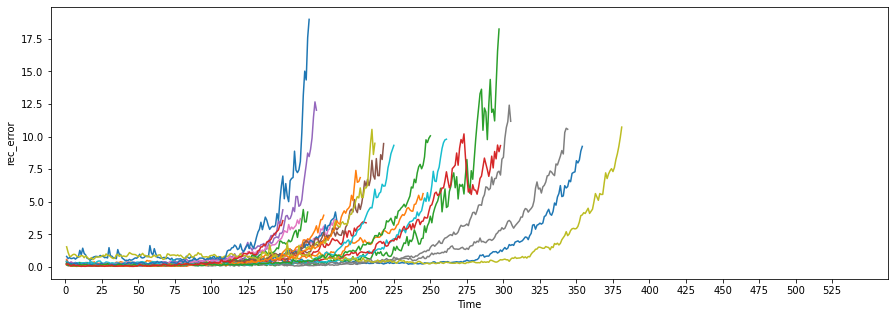

In [81]:
plt_tr.timeplot_column('rec_error')

In [68]:
a = np.empty(0)
for i, d in rul_df.df.groupby(rul_df.id_col):
    x = np.arange(d.shape[0])
    y = np.asarray(d['rec_error'])
    p = np.polyfit(x, y, 3)
    temp = np.array(p[0] * x**3 + p[1] * x**2 + p[2] * x + p[3])
    a = np.append(a,temp)

In [69]:
rul_df.df['rec_error_poly'] = a

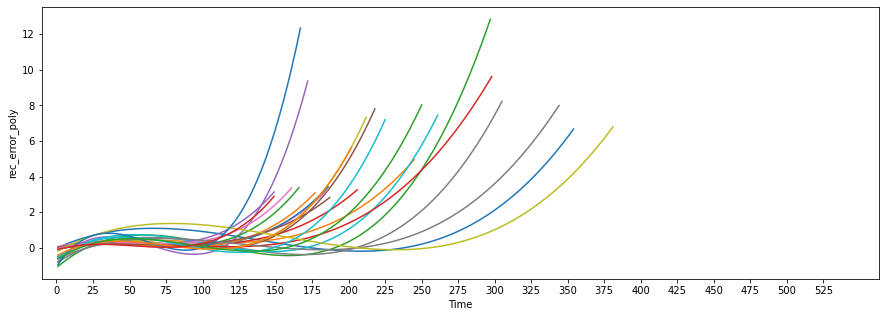

In [70]:
plt_tr.timeplot_column('rec_error_poly')

In [19]:
train_size = ae_train_preprocessed.shape[0]
batch_size = 18

In [94]:
def poly_fit(rul_df, col: str, deg: int = 2) -> None:
        a = np.empty(0)
        for i, d in rul_df.df.groupby(rul_df.id_col):
            x = np.arange(d.shape[0])
            y = np.asarray(d[col])
            p = np.polyfit(x, y, deg)
            temp = np.repeat(p[deg], d.shape[0])
            if deg > 1:
                for j in range(deg):
                    temp = temp + np.array(p[j] * x**(deg-j))
            a = np.append(a,temp)
        rul_df.df[f'{col}_poly_{deg}'] = a
        if not f'{col}_poly_{deg}' in rul_df.label_cols:
            rul_df.label_cols.append(f'{col}_poly_{deg}')
        else:
            print(f'Warning, {col}_poly_{deg} already exists in label cols')

In [102]:
poly_fit(rul_df, 'rec_error', deg=3)

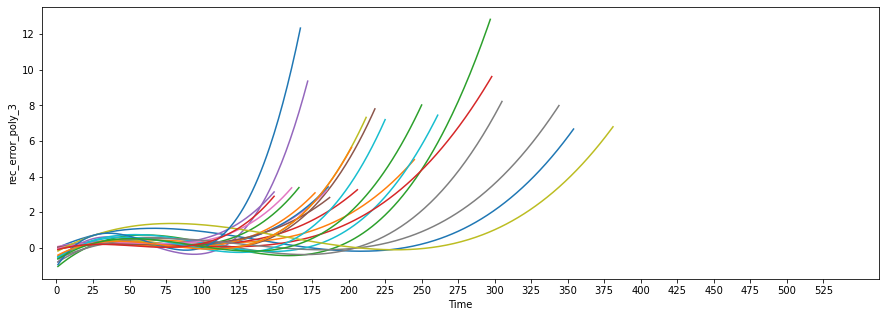

In [103]:
plt_tr.timeplot_column('rec_error_poly_3')

In [104]:
rul_df.label_cols

['linear',
 'rec_error',
 'rec_error',
 'rec_error_poly_2',
 'rec_error_poly_3',
 'rec_error_poly_4',
 'rec_error_poly_3']

In [13]:
train_dataset_pre = (tf.data.Dataset.from_tensor_slices(ae_train_preprocessed).shuffle(train_size).batch(batch_size))

In [150]:
in_dim = ae_train_preprocessed.shape[-1]
ae_pre = VAE_3L(input_dim=in_dim, af='relu')
ae_elbo_pre = VAE_3L_Theory(input_dim=in_dim, af='relu')

In [95]:
epochs = 20
optimizer = tf.keras.optimizers.Adam(1e-4)

In [99]:
for epoch in range(1, epochs + 1):
    for train_x in train_dataset_pre:
        train_step_mse(ae_pre, train_x, optimizer)

In [96]:
for epoch in range(1, epochs + 1):
    for train_x in train_dataset_pre:
        train_step_elbo(ae_elbo_pre, train_x, optimizer)

In [100]:
x_test = np.array(rul_df.df[rul_df.data_cols])
x_test = x_test.astype(np.float64)
prediction = np.array(ae_pre.make_prediction(x_test))
prediction = prediction.astype(np.float64)
prediction2 = np.array(ae_elbo_pre.make_prediction(x_test))
prediction2 = prediction2.astype(np.float64)

In [102]:
reconstruction_error = []
reconstruction_error2 = []
for l in range(x_test.shape[0]):
    reconstruction_error.append(sklearn.metrics.mean_squared_error(x_test[l], prediction[l]))

In [103]:
for l in range(x_test.shape[0]):
    reconstruction_error2.append(sklearn.metrics.mean_squared_error(x_test[l], prediction2[l]))

In [101]:
prediction2

array([[-7.95477509e-01, -1.13313961e+00, -7.54638791e-01, ...,
         7.90311303e-03, -3.76687229e-01, -1.97042018e-01],
       [-7.17087328e-01, -1.05709016e+00, -8.72517467e-01, ...,
         3.34298750e-03, -7.09204018e-01, -8.02773476e-01],
       [-5.92087984e-01, -1.08093441e+00, -8.13174903e-01, ...,
        -1.34720020e-02, -5.38702786e-01, -1.35782272e-01],
       ...,
       [-2.24221841e-01, -5.96074939e-01, -4.13842529e-01, ...,
        -1.96701493e-02,  2.42950499e-01,  1.63230211e-01],
       [-7.47030854e-01,  6.53375834e-02, -5.74184179e-01, ...,
        -1.81720369e-02,  7.48034656e-01,  5.80524027e-01],
       [-5.15384316e-01, -2.12032944e-02, -2.73156077e-01, ...,
        -7.91382743e-04,  6.37016118e-01,  9.62883770e-01]])

In [104]:
rul_df.df['rec_error'] = reconstruction_error
rul_df.df['rec_error_elbo'] = reconstruction_error2
rul_df.label_cols.append('rec_error')
rul_df.label_cols.append('rec_error_elbo')

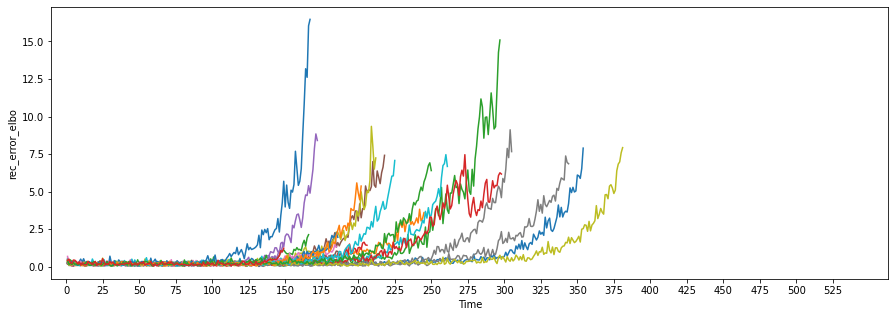

In [105]:
plt_tr.timeplot_column('rec_error_elbo')

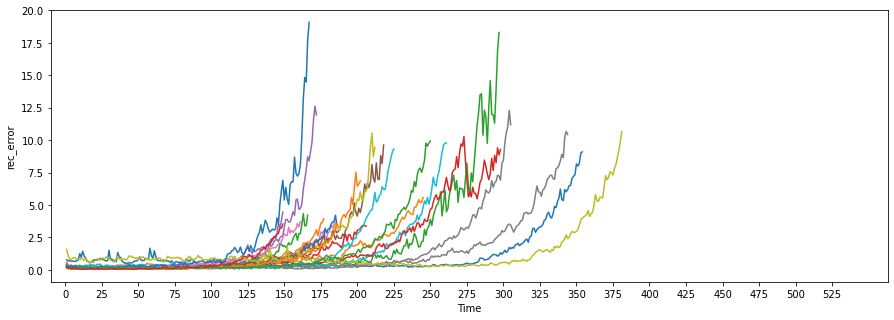

In [106]:
plt_tr.timeplot_column('rec_error')

In [136]:
ae2 = VAE_3L(in_dim,af='relu')
for epoch in range(1, epochs + 1):
    for train_x in train_dataset_pre:
        train_step_mse2(ae2, train_x, optimizer)

In [137]:
prediction3 = np.array(ae2.make_prediction(x_test))
prediction3 = prediction3.astype(np.float64)

In [138]:
reconstruction_error3 = []
for l in range(x_test.shape[0]):
    reconstruction_error3.append(sklearn.metrics.mean_squared_error(x_test[l], prediction3[l]))

In [139]:
rul_df.df['rec_error_3'] = reconstruction_error3
rul_df.label_cols.append('rec_error_3')

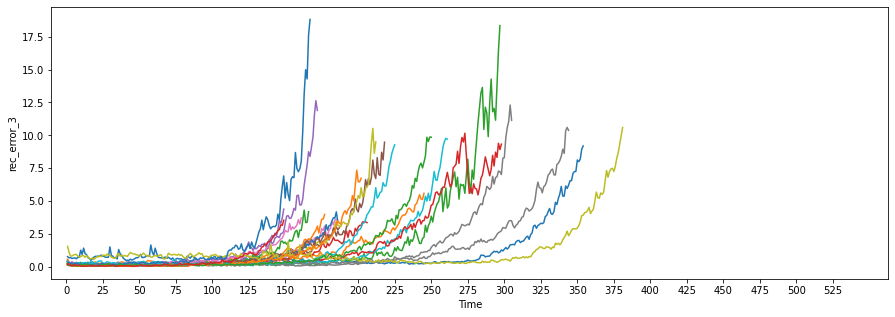

In [140]:
plt_tr.timeplot_column('rec_error_3')

In [127]:
ae3 = VAE_3L(in_dim,af='relu')
for epoch in range(1, epochs + 1):
    for train_x in train_dataset_pre:
        train_step_mse3(ae3, train_x, optimizer)

In [128]:
prediction4 = np.array(ae3.make_prediction(x_test))
prediction4 = prediction4.astype(np.float64)

In [129]:
reconstruction_error4 = []
for l in range(x_test.shape[0]):
    reconstruction_error4.append(sklearn.metrics.mean_squared_error(x_test[l], prediction4[l]))

In [130]:
rul_df.df['rec_error_4'] = reconstruction_error4
rul_df.label_cols.append('rec_error_4')

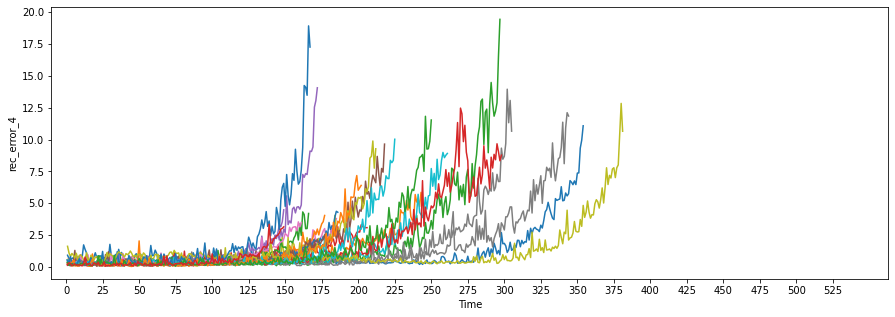

In [131]:
plt_tr.timeplot_column('rec_error_4')

In [26]:
import typing
from typing import Optional
class VariationalAutoencoderELBOMC(Model):
    '''
    Variational Autoencoder.

    Gaussian latent distribution z ~ N(mu, var). Hidden units user specific or of size 
    h1 = Z(input * 1.2), h2 = Z(h1 * 0.5), h3 = Z(h3 * 0.5), given input size.
    
    - Prior distribution N(0,1)
    - Input x -Encoder-> mu, log(var) -Reparametrization-> z ~ N(mu, var) -Decoder-> x*
    - Optimization: max ELBO by using Monte Carlo

    Usage:
    ae = Autoencoder(input_dim)
    ae.compile(optimizer,loss)
    ae.fit(x,x,...)
    '''

    def __init__(self, input_dim: int, hidden_dims: Optional[list[int]] = None,  activation: str = 'relu', **kwargs):
        super(VariationalAutoencoderELBOMC, self).__init__(**kwargs)
        self.input_dim = input_dim

        if hidden_dims == None:
            h1 = int(self.input_dim * 1.2)
            h2 = int(h1 * 0.5)
            self.hidden_dims = [h1, h2]
            self.code_dim = int(h2 * 0.5)
        
        # Encoder, Decoder
        encoder_layers = []
        decoder_layers = []
        debth = len(self.hidden_dims)
        for i in range(1, debth):
            encoder_layers.append(layers.Dense(self.hidden_dims[i], activation = activation))
            decoder_layers.append(layers.Dense(self.hidden_dims[debth - 1 - i], activation = activation))
        self.encoder = tf.keras.Sequential(encoder_layers)
        self.code = layers.Dense(self.code_dim + self.code_dim)
        self.decoder = tf.keras.Sequential(decoder_layers)
        self.output_layer = layers.Dense(self.input_dim)

        self.loss_mean = tf.keras.metrics.Mean(name="loss")
        self.logpxz_mean = tf.keras.metrics.Mean(name="logpxz")
        self.logpz_mean = tf.keras.metrics.Mean(name="logpz")
        self.logqzx_mean = tf.keras.metrics.Mean(name="logqzx")

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.code))
        return self.decode(eps)

    def encode(self, x):
        encoded = self.encoder(x)
        mean, logvar = tf.split(self.code(encoded), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        '''
        eps ~ N(0,1) -> eps * sqrt(var) + mean ~ N(mean, var)
        '''
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        return self.output_layer(decoded)

    def predict(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

    def log_pdf_function(self, sample, mean, logvar):
        '''
        calculates log of probability density function,
        log p(sample), sample ~ Normal(mean, exp(logvar)

        log((1/sqrt(var*2*pi))*exp(-.5((sample-mean)**2/var))
            = -.5 ( (sample-mean)**2 ) / var - .5 logvar - .5 log2pi
        '''
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=1)

    def train_step(self, x):
        with tf.GradientTape() as tape:
            mean, logvar = self.encode(x)
            z = self.reparameterize(mean, logvar)
            reconstruction = self.decode(z)

            logpxz = -tf.keras.losses.binary_crossentropy(x, reconstruction)
            logpz = self.log_pdf_function(z, 0., 0.)
            logqzx = self.log_pdf_function(z, mean, logvar)

            loss = -tf.reduce_mean(logpxz + logpz - logqzx)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        self.loss_mean.update_state(loss),
        self.logpxz_mean.update_state(logpxz),
        self.logpz_mean.update_state(logpz),
        self.logqzx_mean.update_state(logqzx)
        return {
            "loss": self.loss_mean.result(),
            "logpxz": self.logpxz_mean.result(),
            "logpz": self.logpz_mean.result(),
            "logqzx": self.logqzx_mean.result()
        }

In [28]:
ae_train_preprocessed.shape

(15462, 16)

In [29]:
in_dim = ae_train_preprocessed.shape[-1]
ae_pre = VariationalAutoencoderELBOMC(input_dim=in_dim)

In [30]:
ae_pre.compile(optimizer=tf.keras.optimizers.Adam())

In [31]:
ae_pre.fit(ae_train_preprocessed, epochs=20, batch_size=1)

Epoch 1/20
15462/15462 [==============================] - 77s 5ms/step - loss: -3.8516 - logpxz: 3.9278 - logpz: -5.7394 - logqzx: -5.6633
Epoch 2/20
15462/15462 [==============================] - 82s 5ms/step - loss: -3.9786 - logpxz: 3.9898 - logpz: -5.6685 - logqzx: -5.6573
Epoch 3/20
15462/15462 [==============================] - 87s 6ms/step - loss: -3.9794 - logpxz: 3.9854 - logpz: -5.6683 - logqzx: -5.6623
Epoch 4/20
15462/15462 [==============================] - 73s 5ms/step - loss: -3.9935 - logpxz: 3.9974 - logpz: -5.6705 - logqzx: -5.6666
Epoch 5/20
15462/15462 [==============================] - 70s 5ms/step - loss: -4.0047 - logpxz: 4.0076 - logpz: -5.6683 - logqzx: -5.6653
Epoch 6/20
 6747/15462 [============>.................] - ETA: 26s - loss: -3.9902 - logpxz: 3.9928 - logpz: -5.6744 - logqzx: -5.6718

KeyboardInterrupt: 

In [18]:
x_test = np.array(rul_df.df[rul_df.data_cols])
x_test = x_test.astype(np.float64)

In [19]:
prediction = ae_pre.predict(x_test)

In [20]:
reconstruction_error = []
for l in range(x_test.shape[0]):
    reconstruction_error.append(sklearn.metrics.mean_squared_error(x_test[l], prediction[l]))
rul_df.df['rec_error'] = reconstruction_error

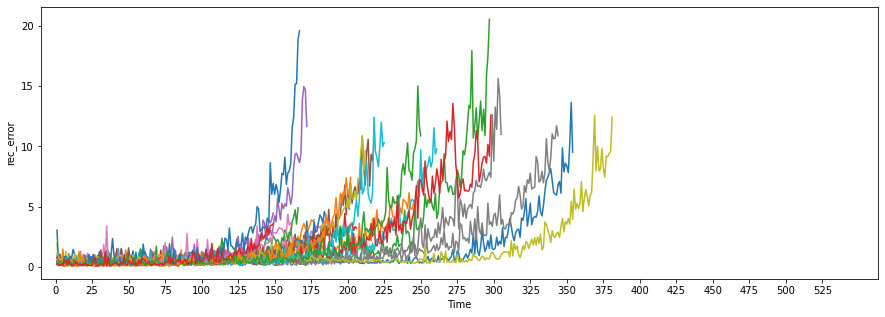

In [21]:
plt_tr.timeplot_column('rec_error')

In [22]:
np.asarray(rul_df.df[rul_df.data_cols])

array([[ 5.99251884e-01, -1.28856235e+00, -1.15950525e+00, ...,
         0.00000000e+00, -3.18207876e-02, -9.09567923e-02],
       [-1.28415970e+00, -9.62149537e-01, -1.20645207e+00, ...,
         0.00000000e+00, -6.57463656e-01, -4.70847488e-01],
       [-1.15876360e+00, -1.15382788e+00, -9.36549217e-01, ...,
         0.00000000e+00, -9.62540357e-01,  1.24775633e-01],
       ...,
       [ 1.90661382e+00,  2.48964971e+00,  2.34714785e+00, ...,
        -2.45884297e-15,  2.58484466e+00,  2.57883744e+00],
       [ 1.38159231e+00,  2.62964151e+00,  2.45600461e+00, ...,
        -1.47530578e-15,  2.73826688e+00,  2.32203696e+00],
       [ 1.22120298e+00,  2.73586143e+00,  2.62541297e+00, ...,
        -8.85183470e-16,  1.77007104e+00,  1.74610874e+00]])